In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings 
warnings.filterwarnings('ignore')

In [36]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [37]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
# scaler_train = StandardScaler()

# X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

# scaler_test = StandardScaler()
# numeric_cols_test = X_test.select_dtypes(include=['number'])
# X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

#### Random UnderSampling

In [38]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


#### Smote-NC

In [39]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-Hot Encoding

In [ ]:
# # Apply one-hot encoding on train and test data
# X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
# X_test_ohe = pd.get_dummies(X_test, drop_first = True)
# X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Pipeline with Lasso (training)

In [43]:
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
        categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [44]:
# Define the pipeline with Lasso for feature selection followed by RandomForest
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [5,10],
    'classifier__max_features': [10, 'log2'],
    'classifier__max_depth': [5,10],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_lasso_pipe = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
cv_lasso_pipe.fit(X_train_smote, y_train_smote)

# Get the best model
best_lasso_pipe = cv_lasso_pipe.best_estimator_



Fitting 5 folds for each of 16 candidates, totalling 80 fits


Python(68422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  34.1s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  34.1s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  34.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  34.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  34.3s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=10; total time=  33.9s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=10; total time=  34.0s
[CV] END classifier__criterion=g


Lasso Pipeline Results:
accuracy: 0.9964181286549708, precision: 0.9959636530575091, recall: 0.9959772478070175, f1: 0.9959704499649065
AUC: 1.0


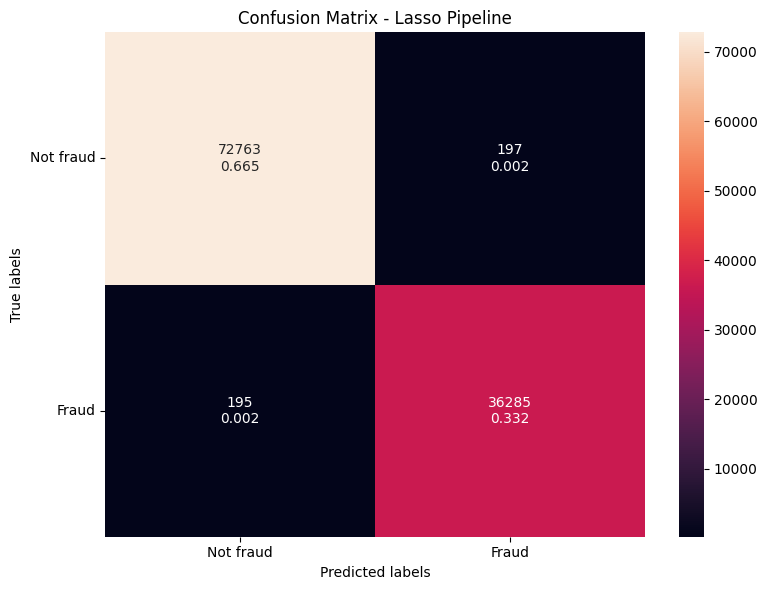

In [45]:
# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_lasso_pipe, X_train_smote, y_train_smote, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_smote, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_smote, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()



Chosen hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 10}
Selected features:
1. num__amt
2. num__hour
3. num__prev_trans_fraud
4. num__count_fraud_7days
5. num__merchant_prev_trans_fraud
6. num__merchant_acc_fraud_count
7. num__hourly_risk_score
8. num__visited_cat

Total selected features: 8 out of 548

Top most important features:
                          Feature  Importance
7                num__visited_cat    0.492755
0                        num__amt    0.201899
2           num__prev_trans_fraud    0.154366
3          num__count_fraud_7days    0.114716
6          num__hourly_risk_score    0.011857
4  num__merchant_prev_trans_fraud    0.011060
1                       num__hour    0.010734
5   num__merchant_acc_fraud_count    0.002613


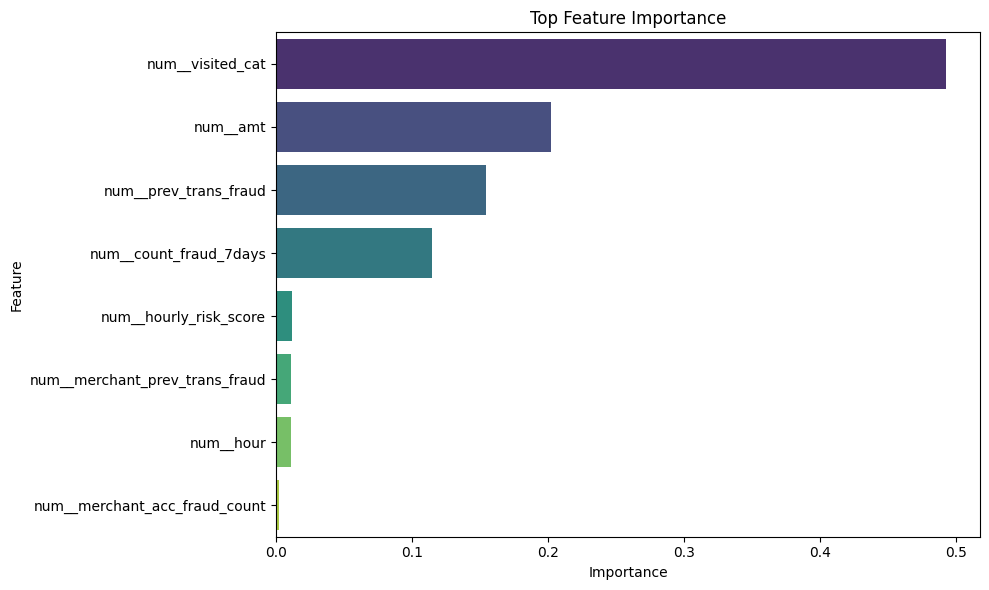

In [51]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_lasso_pipe.best_params_}')

# Get feature names after preprocessing
preprocessor = best_lasso_pipe.named_steps['preprocessor']
preprocessed_features = preprocessor.get_feature_names_out()

# Identify which features were selected
selected_features_mask = best_lasso_pipe.named_steps['feature_selection'].get_support()
selected_features = preprocessed_features[selected_features_mask]  # Use preprocessed_features instead of X_train_smote.columns

# Print selected features 
print("Selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Print total count
print(f"\nTotal selected features: {len(selected_features)} out of {len(preprocessed_features)}")

# Get feature importances from the classifier
feature_importances = best_lasso_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

top10_df = importance_df.sort_values(by='Importance', ascending=False)[:8]

print('\nTop most important features:')
print(top10_df)

# Graph of Features according to their importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Top Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [52]:
print(selected_features)

['num__amt' 'num__hour' 'num__prev_trans_fraud' 'num__count_fraud_7days'
 'num__merchant_prev_trans_fraud' 'num__merchant_acc_fraud_count'
 'num__hourly_risk_score' 'num__visited_cat']


### Performance on Test Data


Test Data Results:
Accuracy: 0.9995
Precision: 0.9291
Recall: 0.9969
F1 Score: 0.9605
AUC: 0.9969


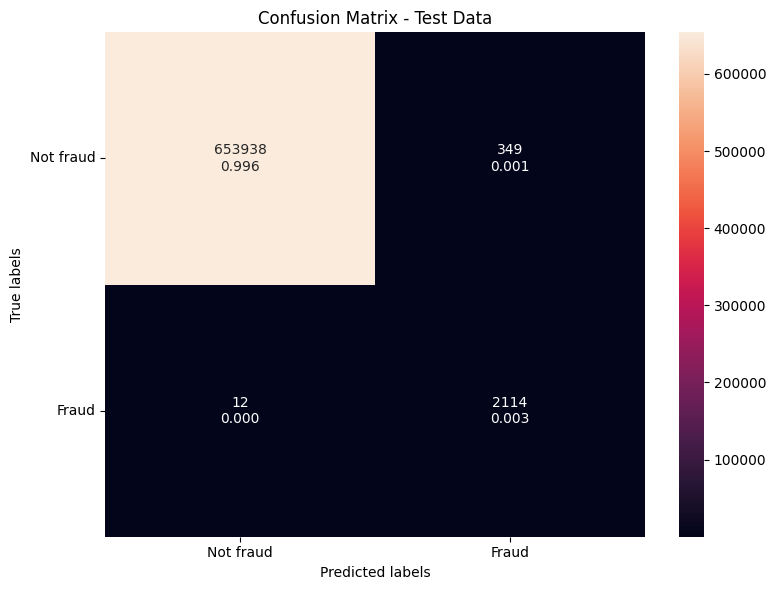

In [47]:
# Use the best model from grid search to predict on test data

y_pred_test = best_lasso_pipe.predict(X_test)

# Calculate evaluation metrics on test data
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_auc = roc_auc_score(y_test, y_pred_test)

# Print test metrics
print("\nTest Data Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_test.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_test.flatten()/np.sum(cm_test)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for test data
ax = plt.subplot()
sns.heatmap(cm_test, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Data')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()